In [ ]:
import pandas as pd
import numpy as np

import re
import string 
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')
tweet

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
#eda
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 90

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Disaster Tweet or Not')

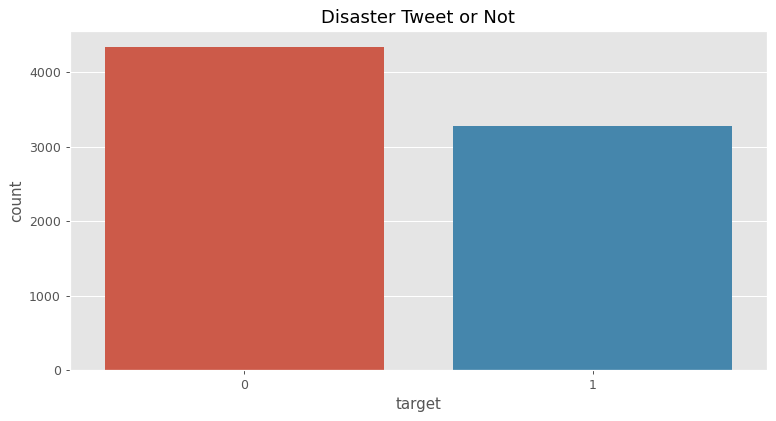

In [ ]:
sns.countplot('target', data=tweet)
plt.title('Disaster Tweet or Not') #0 Not a Disaster tweet, 1 Is a Disaster Tweet


<AxesSubplot:ylabel='target'>

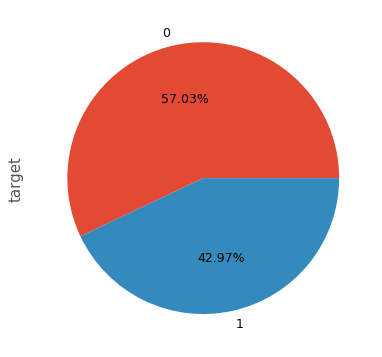

In [ ]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

In [ ]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-fdx41n62
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-fdx41n62
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7650 sha256=921027f7008aad229f363eef28168b14e179c694168903e01b13d472cb650df2
  Stored in directory: /tmp/pip-ephem-wheel-cache-e9jdfh71/wheels/fd/71/47/e04f208ad659a295ccb69022e14de7d20ccc6fc30a5a935f09
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successful

In [ ]:
import preprocess_kgptalkie as kgp

In [ ]:
tweet = kgp.get_basic_features(tweet)

In [ ]:
tweet

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,73,11,6.636364,2,0,0,2,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,106,20,5.300000,9,0,2,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,58,8,7.250000,1,0,0,7,2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,119,19,6.263158,6,0,0,2,0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='char_counts', ylabel='Density'>

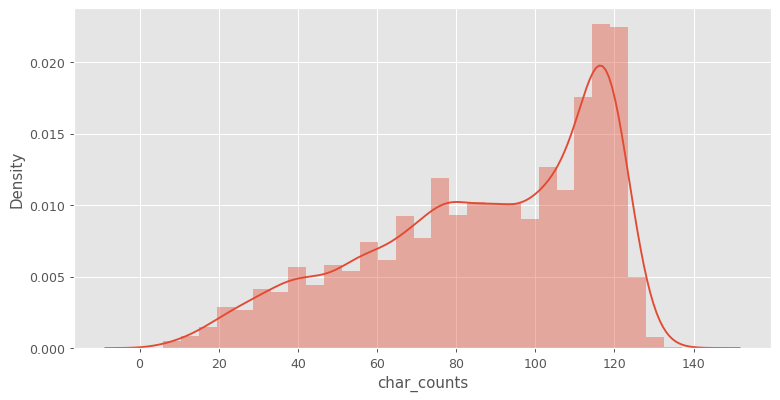

In [ ]:
sns.distplot(tweet['char_counts'])

<AxesSubplot:xlabel='char_counts', ylabel='Density'>

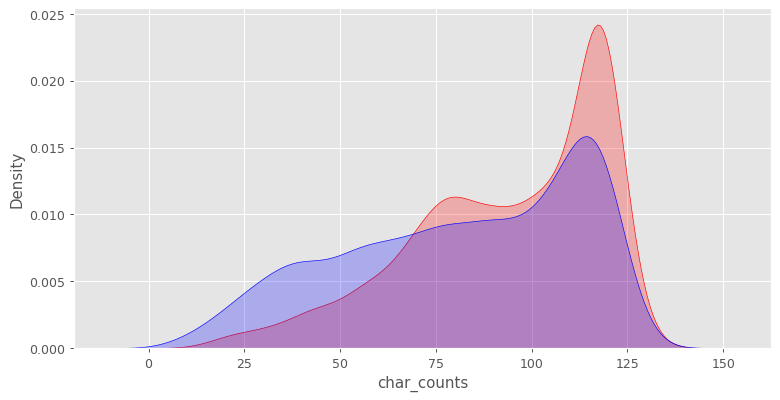

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

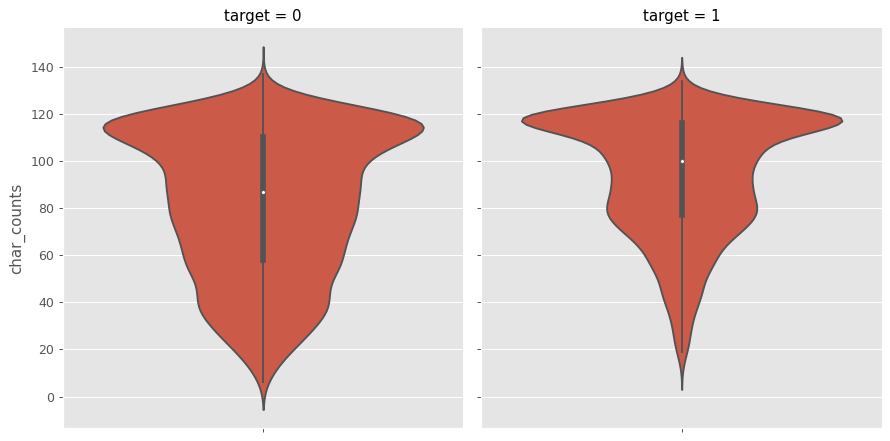

In [ ]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

<AxesSubplot:xlabel='word_counts', ylabel='Density'>

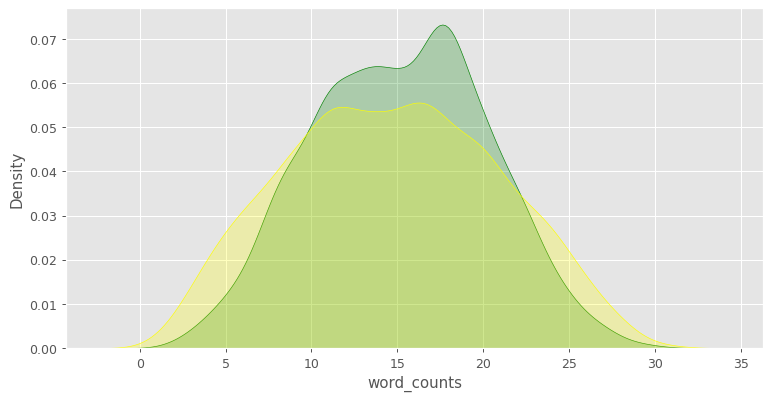

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='yellow')

<AxesSubplot:xlabel='avg_wordlength', ylabel='Density'>

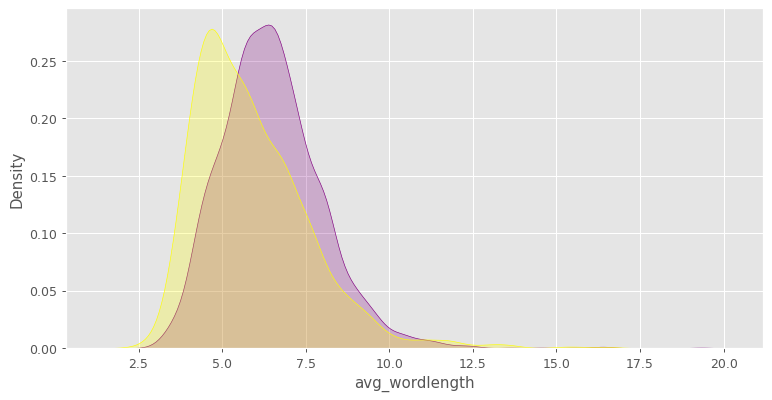

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='purple')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='yellow')

<AxesSubplot:xlabel='stopwords_counts', ylabel='Density'>

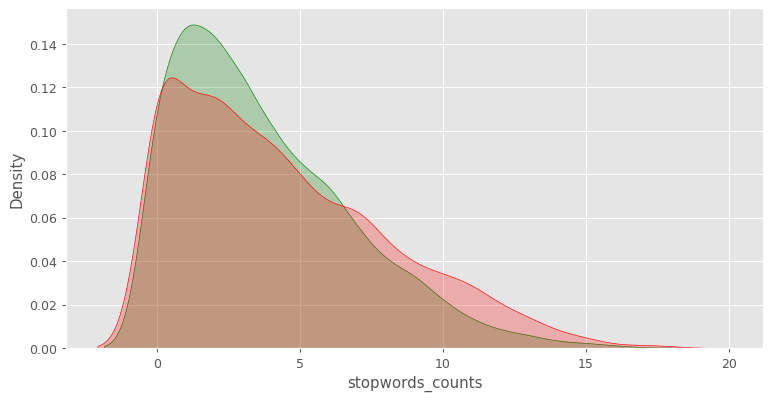

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='red')

In [ ]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [ ]:
#top 20 most frequent words
top20 = freqs[:20]

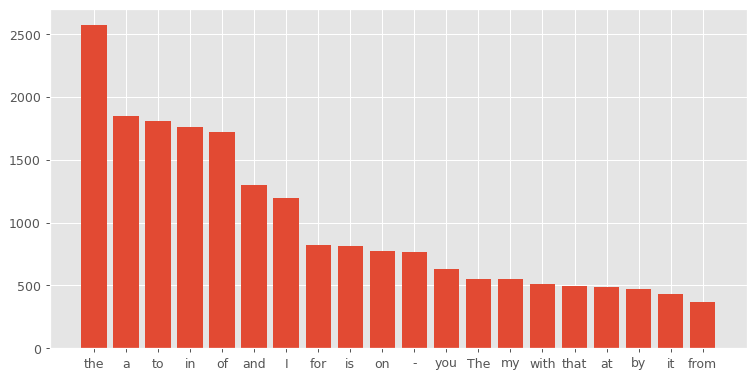

In [ ]:
plt.bar(top20.index, top20.values)
plt.show()

In [ ]:
least20 = freqs[-20:]
least20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
dtype: int64

In [ ]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [ ]:
bigram[:20]

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492),
 ('ûóher upper', 68491),
 ('ûó wallybaiter', 68490),
 ('ûó the', 68489),
 ('ûó stories', 68488),
 ('ûó rt', 68487),
 ('ûó richmond', 68486),
 ('ûó organizers', 68485),
 ('ûó oh', 68484),
 ('ûó now', 68483),
 ('ûó lol', 68482),
 ('ûó integrates', 68481),
 ('ûó https', 68480),
 ('ûó hiroshima', 68479),
 ('ûó head', 68478),
 ('ûó eh', 68477),
 ('ûó desolation', 68476)]

In [ ]:
#preprocess 
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [ ]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

UnicodeDecodeError: ignored

In [ ]:
tweet['text']

In [ ]:
kgp.get_ngram(tweet, 'text', ngram_range=2)


In [ ]:
#visualize with wordcloud
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

In [ ]:
wordcloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
not_real = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
not_real = ' '.join(not_real.index)
wordcloud = WordCloud(max_font_size=100).generate(not_real)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#classification with tfidf and svm
text = tweet['text']
y = tweet['target']

In [ ]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(text)

In [ ]:
x.shape

In [ ]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
#modeling
def run_SVM(clf, x_train, x_test, y_train, y_test):
[ clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)

  print('Classification Report')
  print(classification_report(y_test, y_pred)])

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
run_SVM(clf, x_train, x_test, y_train, y_test)

In [ ]:
 #with tfidf and svm we were able to achieve 81% accuracy, we can do some hyperparameter tuning to fine tune svm to get better predictions

In [ ]:
 #classification with word2vec and svm
 !pip install -U spacy

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
import spacy
import en_core_web_lg

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
x = 'mouse rat'
doc = nlp(x)

In [ ]:
doc.vector.shape

In [ ]:
def get_vector(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [ ]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vector(x))

In [ ]:
tweet.head()

In [ ]:
x = tweet['vec'].to_numpy()
x = x.reshape(-1,1)
x

In [ ]:
x.shape

In [ ]:
x = np.concatenate(np.concatenate(x, axis=0), axis=0).reshape(-1, 300)

In [ ]:
x.shape

In [ ]:
y = tweet['target']

In [ ]:
 x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
%%time
clf = LinearSVC()
run_SVM(clf,x_train, x_test, y_train, y_test)

In [ ]:
#Using word2vec, we were able to achieve 78% accuracy which is worse compared to tfidf
#reason being, word2vec works with vectors which are only present in spacy
#spacy has been trained on standard english, and not twitter data

In [ ]:
#word embeddings and classification with deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [ ]:
text

In [ ]:
token = Tokenizer()
token.fit_on_texts(text)

In [ ]:
vocab_size = len(token.word_index) + 1
vocab_size

In [ ]:
print(token.word_index)

In [ ]:
encoded_text = token.texts_to_sequences(text)

In [ ]:
print(encoded_text)

In [ ]:
max_length = 40
x = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [ ]:
print(x)

In [ ]:
x.shape

In [ ]:
 x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
#build cnn model
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_data=(x_test,y_test))

In [ ]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [ ]:
x = 'Just finished an amazing workout - feeling strong and ready to take on the day! #fitnessmotivation #workoutwednesday'
vec = get_encoded(x)

In [ ]:
np.argmax(model.predict(vec), axis=-1)

In [ ]:
#bert model training
!pip install ktrain

In [ ]:
tweet.head()

In [ ]:
from ktrain import text
import ktrain

In [ ]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=tweet, 
                                                                   text_column='text',
                                                                   label_columns='target', 
                                                                   maxlen=40, #maximum limit for any tweets is 40 tokens
                                                                   preprocess_mode='bert')

In [ ]:
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc)

In [ ]:
#msg = """For a GPU with 12GB of RAM, the following maxima apply:
#sequence len=64, max_batch_size=64
#sequence len=128, max_batch_size=32
#sequence len=256, max_batch_size=16
#sequence len=320, max_batch_size=14
#sequence len=384, max_batch_size=12
#sequence len=512, max_batch_size=6
learner = ktrain.get_learner(model=model,
                   train_data=(x_train, y_train),
                   val_data=(x_test, y_test),
                   batch_size=64)

In [ ]:
#find best learning rate
learner.lr_find()
learner.lr_plot()